### tech valley machine learning meetup kaggle competition prep

* dealing with missing data (there's a lot in these datasets)
* for an earlier treatment of missingness, see [this](https://www.kaggle.com/nikunjm88/carefully-dealing-with-missing-values) kernel

In [1]:
import pandas as pd
import numpy as np
import missingno as msno
from sklearn import neighbors
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sn

In [2]:
%matplotlib inline
palette = sn.color_palette('coolwarm', 9)

In [3]:
# read and merge datasets
properties = pd.read_csv('properties_2016.csv', low_memory = False)
train = pd.read_csv('train_2016_v2.csv', parse_dates = ['transactiondate'])
df = pd.merge(train, properties, on = 'parcelid', how = 'left')
del properties, train
df.head()

,parcelid,logerror,transactiondate,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,buildingclasstypeid,buildingqualitytypeid,...,numberofstories,fireplaceflag,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,taxdelinquencyflag,taxdelinquencyyear,censustractandblock
0,11016594,0.0276,2016-01-01,1.0,NaN,NaN,2.0,3.0,NaN,4.0,...,NaN,NaN,122754.0,360170.0,2015.0,237416.0,6735.88,NaN,NaN,6.037107e+13
1,14366692,-0.1684,2016-01-01,NaN,NaN,NaN,3.5,4.0,NaN,NaN,...,NaN,NaN,346458.0,585529.0,2015.0,239071.0,10153.02,NaN,NaN,NaN
2,12098116,-0.0040,2016-01-01,1.0,NaN,NaN,3.0,2.0,NaN,4.0,...,NaN,NaN,61994.0,119906.0,2015.0,57912.0,11484.48,NaN,NaN,6.037464e+13
3,12643413,0.0218,2016-01-02,1.0,NaN,NaN,2.0,2.0,NaN,4.0,...,NaN,NaN,171518.0,244880.0,2015.0,73362.0,3048.74,NaN,NaN,6.037296e+13
4,14432541,-0.0050,2016-01-02,NaN,NaN,NaN,2.5,4.0,NaN,NaN,...,2.0,NaN,169574.0,434551.0,2015.0,264977.0,5488.96,NaN,NaN,6.059042e+13


#### removing highly correlated variables
we're more concerned with missingness of nonredundant variables, so let's focus on removing those
that are highly correlated

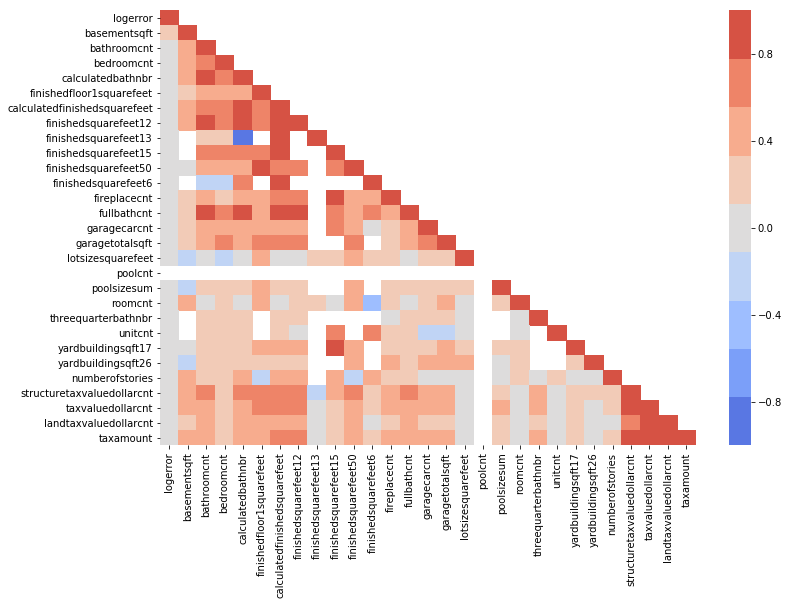

In [4]:
catvars = ['airconditioningtypeid','architecturalstyletypeid','buildingqualitytypeid','buildingclasstypeid',
           'decktypeid','fips','hashottuborspa','heatingorsystemtypeid','pooltypeid10','pooltypeid2','pooltypeid7',
           'propertycountylandusecode','propertylandusetypeid','propertyzoningdesc','rawcensustractandblock','regionidcity',
           'regionidcounty','regionidneighborhood','regionidzip','storytypeid','typeconstructiontypeid','yearbuilt',
           'taxdelinquencyflag', 'latitude', 'longitude', 'parcelid', 'assessmentyear', 'taxdelinquencyyear', 'censustractandblock']

numvars = [i for i in df.columns if i not in catvars]
corr = df[numvars].corr()
mask = np.array(corr)
mask[np.tril_indices_from(mask)] = False
plt.figure(figsize = (12, 8))
sn.heatmap(corr, mask = mask, cmap = palette)

we see several variables with strong correlations. one group centers around taxes: taxvaluedollarcnt, landtaxvaluedollarcnt, and taxamount. 
another group centers around square footage: finishedfloor1squarefeet, finishedsquarefeet12, finishedsquarefeet13, finishedsquarefeet15, finishedsquarefeet50, finishedsquarefeet6, and calculatedfinishedsquarefeet. 
a third group involves bathrooms: fullbathcnt, calculatedbathnbr, and bathroomcnt.


### missing values
#### identifying levels of missingness


In [5]:
missing = df.isnull().sum().sort_values(ascending = False)
vartypes = df.dtypes
missingpercent = (df.isnull().sum()/df['logerror'].count()).sort_values(ascending=False)
pd.concat([vartypes, missing, missingpercent], axis = 1, keys =['var type', 'missing n', 'percent']
                     ).sort_values(by = 'missing n', ascending = False)

,var type,missing n,percent
buildingclasstypeid,float64,90259,0.999823
finishedsquarefeet13,float64,90242,0.999634
basementsqft,float64,90232,0.999524
storytypeid,float64,90232,0.999524
yardbuildingsqft26,float64,90180,0.998948
fireplaceflag,object,90053,0.997541
architecturalstyletypeid,float64,90014,0.997109
typeconstructiontypeid,float64,89976,0.996688
finishedsquarefeet6,float64,89854,0.995336
decktypeid,float64,89617,0.992711


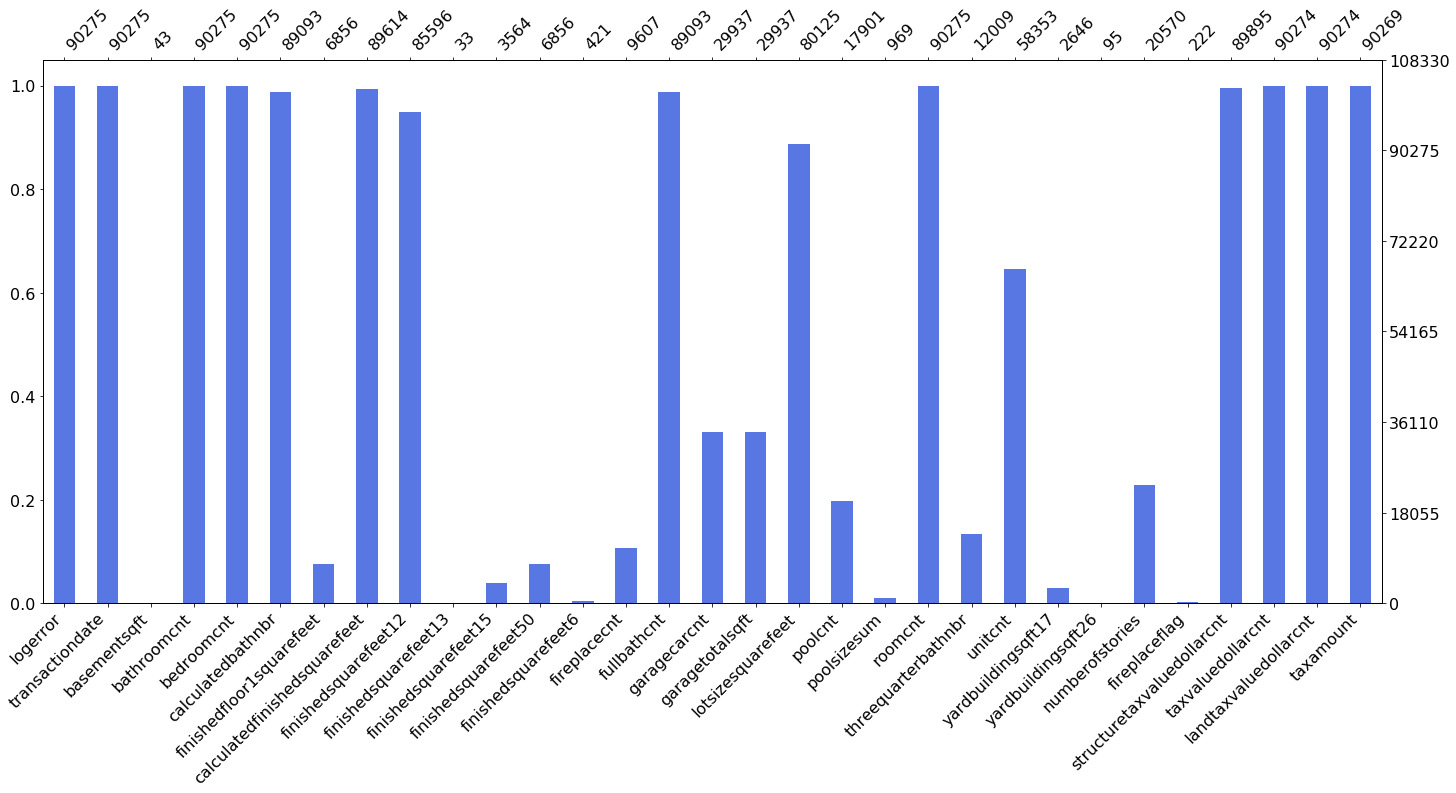

In [6]:
# chart level of completeness of numeric variables
sort = msno.nullity_sort(df[numvars])
msno.bar(sort, color = palette)

the tax group (far right of the graph) has super low levels of missingness, so let's leave those alone for now.
the square footage group has high levels except for calculatedfinishedsquarefeet and finishedsquarefeet12. let's leave those in for now and remove the others.
the bathroom group has one variable with no missing observations: bathroomcnt. the data dictionary entries for the variables in this group suggest they're all pretty much the same thing, so let's leave in this one.

In [7]:
# drop variables
dropcols = ['finishedsquarefeet13', 'finishedsquarefeet15','finishedsquarefeet6', 'calculatedbathnbr', 'fullbathcnt']
df = df.drop(dropcols, axis = 1)

In [8]:
# are there any parcels with no predictor values missing?
completecases = df.dropna(axis = 0, how = 'any')
completecases.shape

(0, 55)

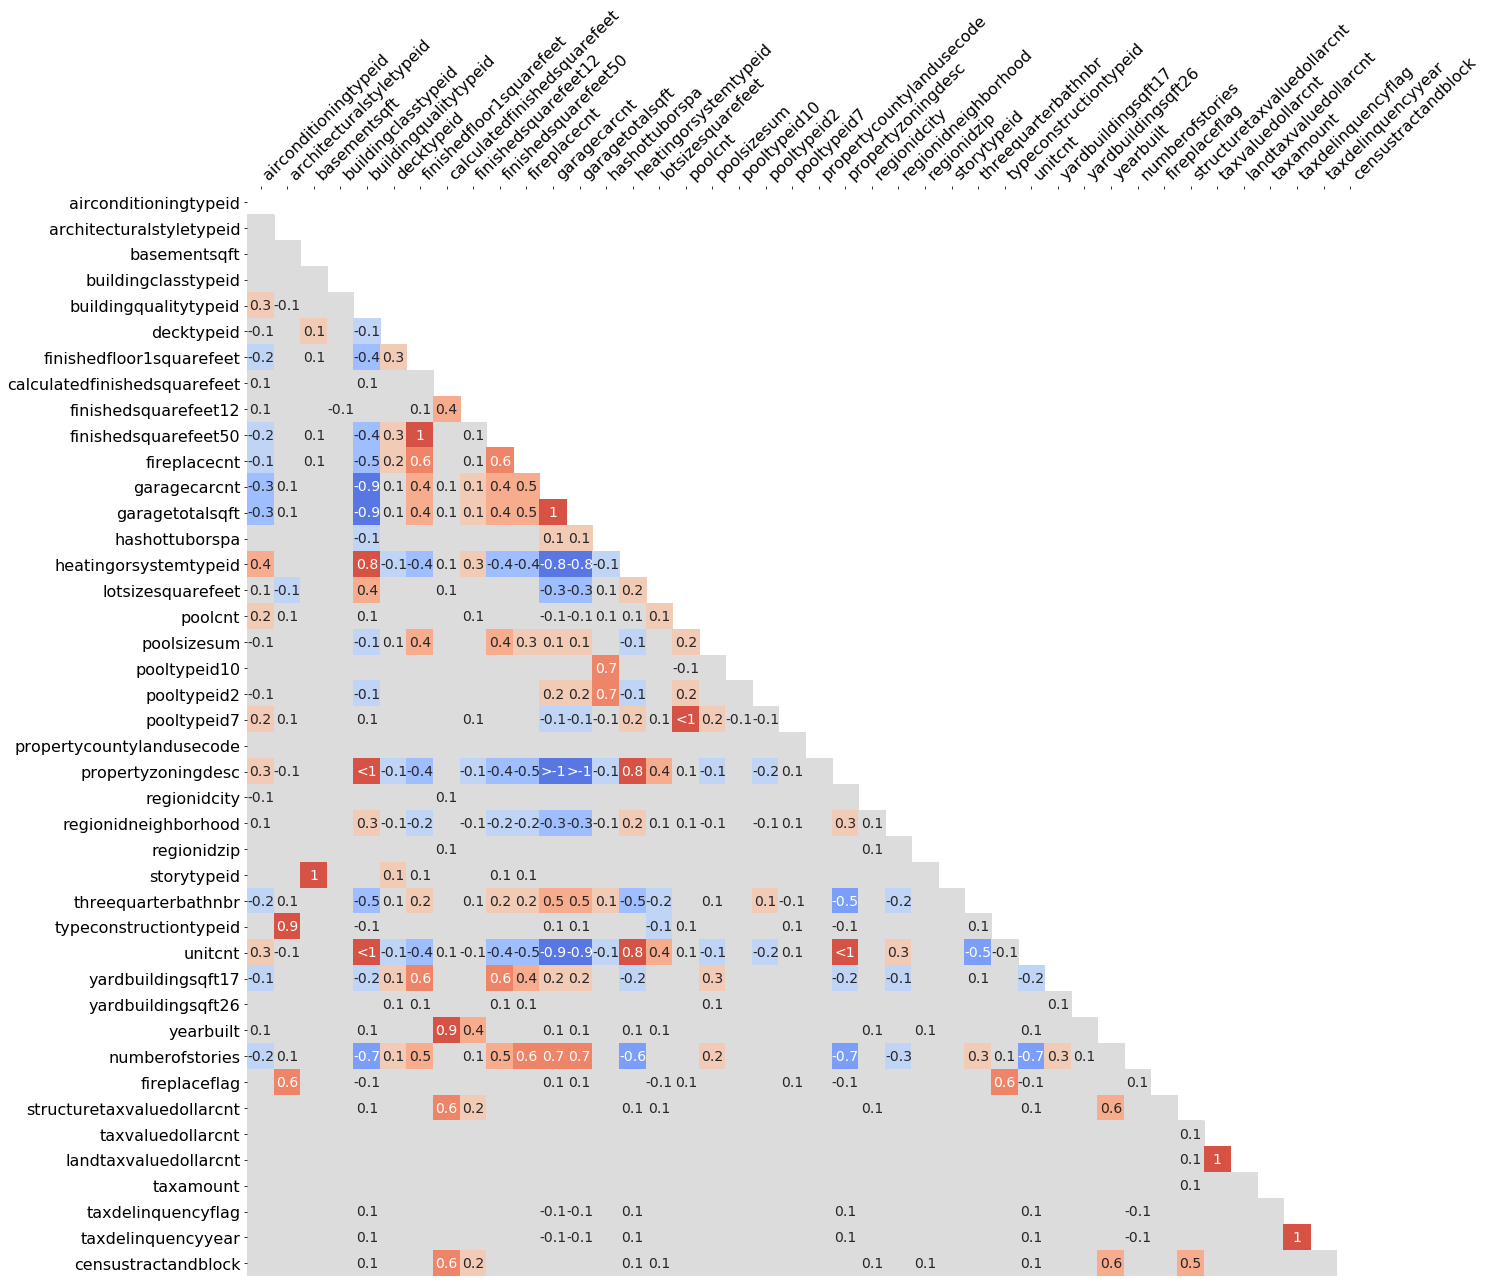

In [10]:
# how strongly does the presence of one predictor affect the presence of another?
## correlation ranges from -1 (if one variable appears the other definitely does not)
## to 0 (variables appearing or not appearing have no effect on one another) 
## to 1 (if one variable appears the other definitely also does)
msno.heatmap(df, figsize = (20, 20), cmap = palette)

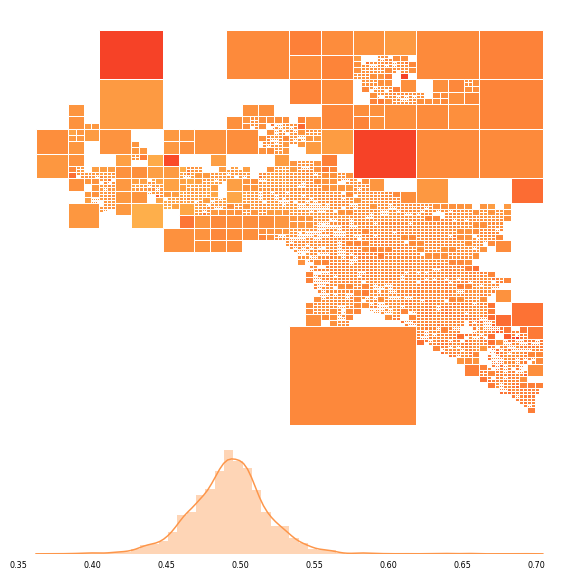

In [11]:
# quadtree nullity distribution: average missingness in ~5 areas is very high (deep colors)
msno.geoplot(df, x = 'longitude', y = 'latitude', histogram = True)

it appears data are missing monotone (we can observe a pattern). the garagecarcnt, garagetotalsqft,  heatingorsystemtypeid, fireplacecnt, unitcnt, buildingqualitytypeid, and numberofstories variables definitely have strong missingness correlations with other variables. also, observations with high missingness seem to cluster in a small number of localities. given this clustering, the k nearest neighbor imputation method is a good place to start.